In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from debugpy.common.log import log_dir
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
WINDOW_SIZE = 10
WINDOW_STEP_SIZE = 1    # WINDOW_SIZE // 3
EPOCHS = 30
STEPS_PER_EPOCH = 100
LEARNING_RATE = 1e-3

In [3]:
ROOTDIR_DATASET = './KukaVelocityDataset'
kuka_column_names_path = os.path.join(ROOTDIR_DATASET, 'KukaColumnNames.npy')
kuka_column_names = np.load(kuka_column_names_path)
kuka_column_names.reshape((1, -1))

array([['action', 'machine_nameKuka Robot_apparent_power',
        'machine_nameKuka Robot_current',
        'machine_nameKuka Robot_frequency',
        'machine_nameKuka Robot_phase_angle',
        'machine_nameKuka Robot_power',
        'machine_nameKuka Robot_power_factor',
        'machine_nameKuka Robot_reactive_power',
        'machine_nameKuka Robot_voltage', 'sensor_id1_AccX',
        'sensor_id1_AccY', 'sensor_id1_AccZ', 'sensor_id1_GyroX',
        'sensor_id1_GyroY', 'sensor_id1_GyroZ', 'sensor_id1_q1',
        'sensor_id1_q2', 'sensor_id1_q3', 'sensor_id1_q4',
        'sensor_id1_temp', 'sensor_id2_AccX', 'sensor_id2_AccY',
        'sensor_id2_AccZ', 'sensor_id2_GyroX', 'sensor_id2_GyroY',
        'sensor_id2_GyroZ', 'sensor_id2_q1', 'sensor_id2_q2',
        'sensor_id2_q3', 'sensor_id2_q4', 'sensor_id2_temp',
        'sensor_id3_AccX', 'sensor_id3_AccY', 'sensor_id3_AccZ',
        'sensor_id3_GyroX', 'sensor_id3_GyroY', 'sensor_id3_GyroZ',
        'sensor_id3_q1', 'sensor_i

In [4]:
kuka_normal_path = os.path.join(ROOTDIR_DATASET, 'KukaNormal.npy')
kuka_normal = np.load(kuka_normal_path)
kuka_normal = np.hstack((kuka_normal, np.zeros(kuka_normal.shape[0]).reshape(-1, 1) ))
kuka_normal = kuka_normal.astype('float32')
kuka_normal = (kuka_normal - np.min(kuka_normal)) / (np.max(kuka_normal) - np.min(kuka_normal))

kuka_normal = np.vstack((kuka_column_names, kuka_normal))
df_kuka_normal = pd.DataFrame(kuka_normal)
df_kuka_normal.columns = df_kuka_normal.iloc[0]
df_kuka_normal = df_kuka_normal.iloc[1:]

df_kuka_normal.drop("anomaly", axis=1, inplace=True)
df_kuka_normal = df_kuka_normal.reset_index(drop=True)
# df_kuka_normal['machine_nameKuka Robot_time'] = df_kuka_normal.index.astype(float) /  df_kuka_normal['machine_nameKuka Robot_frequency'].astype(float)

df_kuka_normal

,action,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_frequency,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,sensor_id1_AccX,...,sensor_id7_AccY,sensor_id7_AccZ,sensor_id7_GyroX,sensor_id7_GyroY,sensor_id7_GyroZ,sensor_id7_q1,sensor_id7_q2,sensor_id7_q3,sensor_id7_q4,sensor_id7_temp
0,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.49987328,...,0.5000448,0.50029606,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
1,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.4998734,...,0.5000438,0.5002962,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
2,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.49987352,...,0.50004494,0.50029594,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
3,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.49987328,...,0.5000446,0.5002962,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
4,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.49987388,...,0.50004435,0.5002956,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233787,0.5000458,0.5401675,0.5002942,0.5125477,0.5804533,0.53148186,0.5002417,0.4751176,0.55781376,0.49985716,...,0.5000452,0.50029594,0.5000458,0.5000458,0.5000458,0.5000026,0.50003374,0.5001087,0.5002836,0.54511267
233788,0.5000458,0.5401675,0.5002942,0.5125477,0.5804533,0.53148186,0.5002417,0.4751176,0.55781376,0.49985802,...,0.50004506,0.50029606,0.5000458,0.5000458,0.5000458,0.5000026,0.50003374,0.5001087,0.5002836,0.54511267
233789,0.5000458,0.5401675,0.5002942,0.5125477,0.5804533,0.53148186,0.5002417,0.4751176,0.55781376,0.49985716,...,0.50004494,0.5002957,0.5000458,0.5000458,0.5000458,0.5000026,0.50003374,0.5001087,0.5002836,0.54511267
233790,0.5000458,0.5401675,0.5002942,0.5125477,0.5804533,0.53148186,0.5002417,0.4751176,0.55781376,0.49985507,...,0.5000446,0.5002958,0.5000458,0.50006104,0.5000458,0.50000256,0.50003374,0.5001087,0.5002836,0.54511267


In [5]:
df_kuka_normal['action'].astype(float).unique()

array([0.5000458 , 0.5002958 , 0.50054586, 0.5007959 , 0.50104594,
       0.501296  , 0.501546  , 0.50179607, 0.5020461 , 0.50229615,
       0.5025462 , 0.50279623, 0.5030462 , 0.50329626, 0.5035463 ,
       0.50379634, 0.5040464 , 0.5042964 , 0.50454646, 0.5047965 ,
       0.50504655, 0.5052966 , 0.5055466 , 0.5057967 , 0.5060467 ,
       0.50629675, 0.5065468 , 0.50679684, 0.5070469 , 0.50729686,
       0.5075469 , 0.50779694])

In [6]:
kuka_slow_path = os.path.join(ROOTDIR_DATASET, 'KukaSlow.npy')
kuka_slow = np.load(kuka_slow_path)
kuka_slow = kuka_slow.astype('float32')
kuka_slow = (kuka_slow - np.min(kuka_slow)) / (np.max(kuka_slow) - np.min(kuka_slow))

kuka_slow = np.vstack((kuka_column_names, kuka_slow))

df_kuka_slow = pd.DataFrame(kuka_slow)
df_kuka_slow.columns = df_kuka_slow.iloc[0]
df_kuka_slow = df_kuka_slow.iloc[1:]
df_kuka_slow = df_kuka_slow.reset_index(drop=True)
df_kuka_slow.drop("anomaly", axis=1, inplace=True)
# df_kuka_slow['machine_nameKuka Robot_time'] = df_kuka_slow.index.astype(float) /  df_kuka_slow['machine_nameKuka Robot_frequency'].astype(float)
df_kuka_slow

,action,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_frequency,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,sensor_id1_AccX,...,sensor_id7_AccY,sensor_id7_AccZ,sensor_id7_GyroX,sensor_id7_GyroY,sensor_id7_GyroZ,sensor_id7_q1,sensor_id7_q2,sensor_id7_q3,sensor_id7_q4,sensor_id7_temp
0,0.550076,0.6067533,0.5476623,0.5610488,0.6380664,0.59918267,0.5475722,0.51831156,0.6099998,0.54716,...,0.54735816,0.5476133,0.5470649,0.5448548,0.55836654,0.547275,0.5473366,0.5472404,0.54758453,0.5967761
1,0.550076,0.6067533,0.5476623,0.5610488,0.6380664,0.59918267,0.5475722,0.51831156,0.6099998,0.54716,...,0.54733306,0.54761064,0.5472826,0.54676354,0.54917455,0.5472748,0.54733574,0.54724574,0.5475864,0.5967761
2,0.550076,0.6067533,0.5476623,0.5610354,0.6380664,0.59918267,0.5475722,0.51831156,0.6099998,0.54719836,...,0.5473482,0.5476125,0.5473328,0.5472826,0.5472993,0.5472756,0.5473368,0.547246,0.5475866,0.5967761
3,0.550076,0.6067533,0.5476623,0.5610354,0.6380664,0.59918267,0.5475722,0.51831156,0.6099998,0.54716176,...,0.5473267,0.5476042,0.5473496,0.54738307,0.5472491,0.5472763,0.5473376,0.5472461,0.5475868,0.5967761
4,0.550076,0.6067533,0.5476623,0.5610354,0.6380664,0.59918267,0.5475722,0.51831156,0.6099998,0.54717046,...,0.54732543,0.5476038,0.5472993,0.5473663,0.547517,0.54727685,0.54733825,0.5472462,0.5475869,0.5967761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41533,0.5473328,0.6067829,0.5476799,0.5610354,0.6376725,0.5984644,0.54756874,0.5170063,0.61008596,0.5471686,...,0.5473347,0.54761034,0.5473328,0.5446372,0.5589023,0.5472899,0.547303,0.54744023,0.54757977,0.5967761
41534,0.5473328,0.6067829,0.5476799,0.5610354,0.6376725,0.5984644,0.54756874,0.5170063,0.61008596,0.5471686,...,0.547337,0.54760474,0.5472993,0.54467064,0.5586177,0.5472911,0.5472999,0.5474488,0.54757565,0.5967761
41535,0.5473328,0.6067829,0.5476799,0.5610354,0.6376725,0.5984644,0.54756874,0.5170063,0.61008596,0.5471686,...,0.5473308,0.5476109,0.5473328,0.5446874,0.5588521,0.54729235,0.547297,0.5474568,0.5475715,0.5967761
41536,0.5473328,0.6067829,0.5476799,0.5610354,0.6376725,0.5984644,0.54756874,0.5170063,0.61008596,0.5471686,...,0.5473386,0.54760647,0.5471989,0.5446037,0.5584503,0.54729366,0.547294,0.54746515,0.5475667,0.5967761


In [7]:
a: np.ndarray = df_kuka_slow['action'].astype(float).unique()
a.sort()
a

array([0.5473328 , 0.5476071 , 0.5478815 , 0.5481558 , 0.5484301 ,
       0.54870445, 0.54897875, 0.54925305, 0.54952735, 0.550076  ,
       0.5503503 , 0.55062467, 0.55089897, 0.55117327, 0.55144763,
       0.55172193, 0.55199623, 0.5522706 , 0.5525449 , 0.5528192 ,
       0.55309355, 0.55336785, 0.55364215, 0.5539165 , 0.5541908 ,
       0.5544651 , 0.5547394 , 0.5550138 , 0.5552881 , 0.5555624 ,
       0.55583674])

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self, window_size):
        super(Encoder, self).__init__()
        # n_feature = 86
        # Input size: (n_feature, window_size)
        self.conv1d_1 = tf.keras.layers.Conv1D(filters=window_size*2, kernel_size=7, strides=1, padding='valid')
        # size: (80, window_size*2)
        self.conv1d_2 = tf.keras.layers.Conv1D(filters=window_size*4, kernel_size=4, strides=2, padding='same')
        # size: (40, window_size*4)
        self.conv1d_3 = tf.keras.layers.Conv1D(filters=window_size*8, kernel_size=4, strides=2, padding='same')
        # size: (20, window_size*8)
        self.conv1d_4 = tf.keras.layers.Conv1D(filters=window_size*16, kernel_size=4, strides=2, padding='same')
        # size: (10, window_size*16)
        self.conv1d_5 = tf.keras.layers.Conv1D(filters=window_size*32, kernel_size=10, strides=1, padding='valid')
        # size: (1, window_size*32)
        
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()

    def build(self, input_shape):
        super(Encoder, self).build(input_shape)

    def call(self, X):
        X = self.conv1d_1(X)
        X = self.batch_norm_1(X)
        X = tf.nn.leaky_relu(X)

        X = self.conv1d_2(X)
        X = self.batch_norm_2(X)
        X = tf.nn.leaky_relu(X)

        X = self.conv1d_3(X)
        X = self.batch_norm_3(X)
        X = tf.nn.leaky_relu(X)

        X = self.conv1d_4(X)
        X = self.batch_norm_4(X)
        X = tf.nn.leaky_relu(X)
        
        X = self.conv1d_5(X)
        
        return X


class Decoder(tf.keras.Model):
    def __init__(self, window_size):
        super(Decoder, self).__init__()
        # Input size: (1, window_size*32)
        self.conv_transpose_1d_1 = tf.keras.layers.Conv1DTranspose(filters=window_size*16, kernel_size=10, strides=1, padding='valid')
        # size: (10, window_size*16)
        self.conv_transpose_1d_2 = tf.keras.layers.Conv1DTranspose(filters=window_size*8, kernel_size=4, strides=2, padding='same')
        # size: (20, window_size*8)
        self.conv_transpose_1d_3 = tf.keras.layers.Conv1DTranspose(filters=window_size*4, kernel_size=4, strides=2, padding='same')
        # size: (40, window_size*4)
        self.conv_transpose_1d_4 = tf.keras.layers.Conv1DTranspose(filters=window_size*2, kernel_size=4, strides=2, padding='same')
        # size: (80, window_size*2)
        self.conv_transpose_1d_5 = tf.keras.layers.Conv1DTranspose(filters=window_size, kernel_size=7, strides=1, padding='valid')
        # size: (86, window_size)
        
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()

    def build(self, input_shape):
        super(Decoder, self).build(input_shape)

    def call(self, X):
        X = self.conv_transpose_1d_1(X)
        X = self.batch_norm_1(X)
        X = tf.nn.relu(X)
        
        X = self.conv_transpose_1d_2(X)
        X = self.batch_norm_2(X)
        X = tf.nn.relu(X)

        X = self.conv_transpose_1d_3(X)
        X = self.batch_norm_3(X)
        X = tf.nn.relu(X)
        
        X = self.conv_transpose_1d_4(X)
        X = self.batch_norm_4(X)
        X = tf.nn.relu(X)
        
        X = self.conv_transpose_1d_5(X)
        
        return X
    

class AutoEncoder(tf.keras.Model):
    def __init__(self, window_size):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(window_size)
        self.decoder = Decoder(window_size)

    def build(self, input_shape):
        super(AutoEncoder, self).build(input_shape)

    def call(self, X):
        latent = self.encoder(X)
        X = self.decoder(latent)

        return X

In [9]:
df_kuka_normal.iloc[:1000]

,action,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_frequency,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,sensor_id1_AccX,...,sensor_id7_AccY,sensor_id7_AccZ,sensor_id7_GyroX,sensor_id7_GyroY,sensor_id7_GyroZ,sensor_id7_q1,sensor_id7_q2,sensor_id7_q3,sensor_id7_q4,sensor_id7_temp
0,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.49987328,...,0.5000448,0.50029606,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
1,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.4998734,...,0.5000438,0.5002962,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
2,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.49987352,...,0.50004494,0.50029594,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
3,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.49987328,...,0.5000446,0.5002962,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
4,0.5000458,0.54084253,0.50029004,0.5125477,0.5802353,0.53162146,0.5002393,0.47421497,0.5571351,0.49987388,...,0.50004435,0.5002956,0.5000458,0.5000458,0.5000458,0.50002486,0.5000856,0.49982718,0.50015855,0.54511267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.5007959,0.54576683,0.50026786,0.51253545,0.58298796,0.5403097,0.50026596,0.47838613,0.55721474,0.49975705,...,0.5000419,0.5002874,0.50009155,0.5039221,0.48293808,0.50004256,0.5000936,0.49980995,0.5001136,0.54511267
996,0.5007959,0.54576683,0.50026786,0.51253545,0.58298796,0.5403097,0.50026596,0.47838613,0.55721474,0.4997955,...,0.5000509,0.50030863,0.5002442,0.50410527,0.48353326,0.5000475,0.50009507,0.4998067,0.50009996,0.54511267
997,0.5007959,0.54576683,0.50026786,0.51253545,0.58298796,0.5403097,0.50026596,0.47838613,0.55721474,0.49985558,...,0.50004077,0.50031537,0.50006104,0.5041205,0.483167,0.5000524,0.5000963,0.49980435,0.5000861,0.54511267
998,0.5007959,0.54576683,0.50026786,0.51253545,0.58298796,0.5403097,0.50026596,0.47838613,0.55721474,0.49973458,...,0.50005263,0.5002907,0.5000458,0.50276226,0.4892409,0.5000563,0.5000971,0.49980292,0.5000738,0.54511267


In [10]:
def sliding_window(data, window_size, step_size):
    windows = []
    for i in range(0, data.shape[0] - window_size + 1, step_size):
        windows.append(data.iloc[i:i + window_size].to_numpy().astype('float32'))
    
    x = np.array(windows).astype('float32')
    return np.swapaxes(x,1,2)

train_data = sliding_window(df_kuka_normal, WINDOW_SIZE, WINDOW_STEP_SIZE)

In [11]:
train_data.shape

(233783, 86, 10)

In [12]:
autoencoder: AutoEncoder = AutoEncoder(WINDOW_SIZE)
autoencoder.build(train_data.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).repeat().batch(256)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.fit(train_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, callbacks=[callback, tensorboard_callback])
autoencoder.summary()

2024-06-19 23:35:19.664837: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-06-19 23:35:19.664876: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-19 23:35:19.664914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-19 23:35:19.664939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-19 23:35:19.664958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2024-06-19 23:35:22.265815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0816
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0020
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 2.9333e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 4.9424e-05
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 2.6025e-05
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.1099e-05
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.7214e-05
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2.2038e-05


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │       582,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │       582,110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,491,192 (13.32 MB)

 Trainable params: 1,163,330 (4.44 MB)

 Non-trainable params: 1,200 (4.69 KB)

 Optimizer params: 2,326,662 (8.88 MB)

In [13]:
"""
start_time = time()
encoded_data = autoencoder.encoder(train_data).numpy()
print(train_data.shape)
decoded_data = autoencoder.decoder(encoded_data).numpy()
print(decoded_data.shape)
end_time = time()
print(f'Time taken to decode data: {end_time - start_time}')
"""

"\nstart_time = time()\nencoded_data = autoencoder.encoder(train_data).numpy()\nprint(train_data.shape)\ndecoded_data = autoencoder.decoder(encoded_data).numpy()\nprint(decoded_data.shape)\nend_time = time()\nprint(f'Time taken to decode data: {end_time - start_time}')\n"

In [14]:
train_data[0, :, 0]

array([0.5000458 , 0.54084253, 0.50029004, 0.5125477 , 0.5802353 ,
       0.53162146, 0.5002393 , 0.47421497, 0.5571351 , 0.49987328,
       0.4999928 , 0.49985972, 0.5000458 , 0.5000458 , 0.5000458 ,
       0.49981418, 0.5000542 , 0.5001344 , 0.5000766 , 0.5360813 ,
       0.50016785, 0.5000545 , 0.5002559 , 0.5000458 , 0.5000458 ,
       0.5000458 , 0.5001128 , 0.5000443 , 0.50027835, 0.5001085 ,
       0.5360813 , 0.50002956, 0.500029  , 0.499791  , 0.5000458 ,
       0.5000458 , 0.5000458 , 0.4999896 , 0.4998024 , 0.50005543,
       0.50004005, 0.5360813 , 0.5000764 , 0.4999006 , 0.5002448 ,
       0.5000458 , 0.5000458 , 0.5000458 , 0.5000091 , 0.49997592,
       0.5002282 , 0.50019747, 0.5360813 , 0.5000523 , 0.49986607,
       0.4998564 , 0.5000458 , 0.5000458 , 0.5000458 , 0.49981517,
       0.5000719 , 0.50003195, 0.5001377 , 0.5360813 , 0.50005287,
       0.50009304, 0.5003028 , 0.5000458 , 0.5000458 , 0.5000458 ,
       0.50006306, 0.5000607 , 0.5002365 , 0.5002058 , 0.54511

In [15]:
start_time = time()
normal_reconstructions = autoencoder.predict(train_data)
end_time = time()
print(f'Time taken to reconstruct: {end_time - start_time}')

normal_train_loss = tf.keras.losses.mse(normal_reconstructions, train_data)

7306/7306 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
Time taken to reconstruct: 28.288286924362183


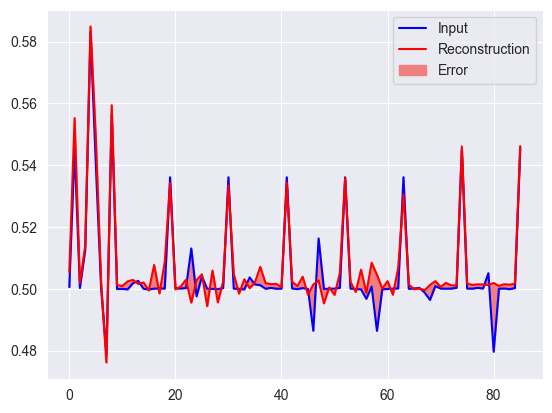

In [16]:
sample_inside_window = 4 # from 0 to 10
window_number = 38000 # from 0 to the number of windows created

# Plot the reconstruction error for each feature
plt.plot(train_data[window_number, :, sample_inside_window], 'b')
plt.plot(normal_reconstructions[window_number, :, sample_inside_window], 'r')
plt.fill_between(np.arange(86), normal_reconstructions[window_number, :, sample_inside_window], train_data[window_number, :, sample_inside_window], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [17]:
mean_mse = np.mean(normal_train_loss, axis=1)
mean_mse[None, :].shape

(1, 233783)

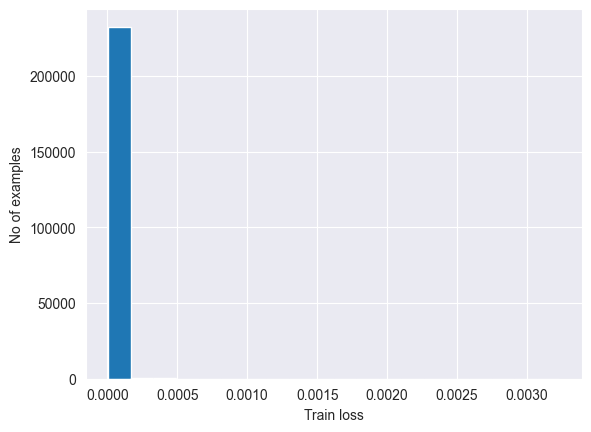

In [18]:
plt.hist(mean_mse[:, None], bins=20)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [19]:
threshold = np.mean(mean_mse) + np.std(mean_mse)
print("Threshold: ", threshold)

Threshold:  5.7781428e-05


1298/1298 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


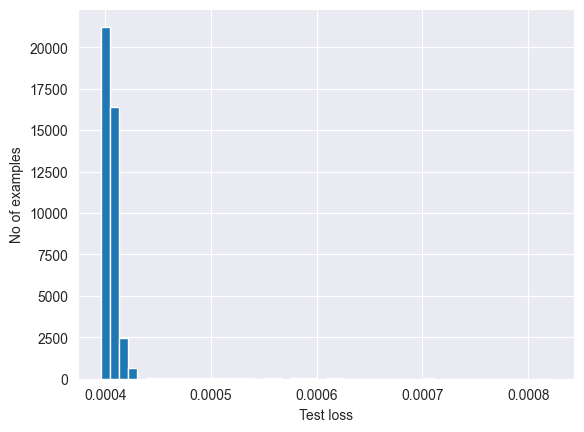

In [20]:
test_data = sliding_window(df_kuka_slow, WINDOW_SIZE, WINDOW_STEP_SIZE)

reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mse(reconstructions, test_data)

mean_mse_test = np.mean(test_loss, axis=1)

plt.hist(mean_mse_test[:, None], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [21]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  mean_mse_test = np.mean(loss, axis=1)
  return tf.math.less(mean_mse_test, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
  print("F1 = {}".format(f1_score(labels, predictions)))

In [22]:
preds = predict(autoencoder, test_data, threshold)
print_stats(np.bitwise_not(preds), np.ones_like(preds))

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1 = 1.0


In [23]:
print(preds.shape)
print(np.zeros_like(preds).shape)
preds

(41529,)
(41529,)


<tf.Tensor: shape=(41529,), dtype=bool, numpy=array([False, False, False, ..., False, False, False])>

In [24]:
np.where(preds == False)[0].shape

(41529,)

In [25]:
class Discriminator(tf.keras.Model):
    def __init__(self, window_size):
        super(Discriminator, self).__init__()
        # n_feature = 86
        # Input size: (n_feature, window_size)
        self.conv1d_1 = tf.keras.layers.Conv1D(filters=window_size*2, kernel_size=7, strides=1, padding='valid')
        # size: (80, window_size*2)
        self.conv1d_2 = tf.keras.layers.Conv1D(filters=window_size*4, kernel_size=4, strides=2, padding='same')
        # size: (40, window_size*4)
        self.conv1d_3 = tf.keras.layers.Conv1D(filters=window_size*8, kernel_size=4, strides=2, padding='same')
        # size: (20, window_size*8)
        self.conv1d_4 = tf.keras.layers.Conv1D(filters=window_size*16, kernel_size=4, strides=2, padding='same')
        # size: (10, window_size*16)
        self.conv1d_5 = tf.keras.layers.Conv1D(filters=window_size*32, kernel_size=10, strides=1, padding='valid')
        # size: (1, window_size*32)
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.dense_1 = tf.keras.layers.Dense(window_size*8, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(window_size*4, activation='relu')
        self.dense_3 = tf.keras.layers.Dense(window_size, activation='relu')
        
        self.softmax_1 = tf.keras.layers.Dense(1, activation='sigmoid')
        
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()
        self.batch_norm_5 = tf.keras.layers.BatchNormalization()
        self.batch_norm_6 = tf.keras.layers.BatchNormalization()
        self.batch_norm_7 = tf.keras.layers.BatchNormalization()

    def build(self, input_shape):
        super(Discriminator, self).build(input_shape)

    def call(self, X):
        X = self.conv1d_1(X)
        X = self.batch_norm_1(X)
        X = tf.nn.leaky_relu(X)

        X = self.conv1d_2(X)
        X = self.batch_norm_2(X)
        X = tf.nn.leaky_relu(X)

        X = self.conv1d_3(X)
        X = self.batch_norm_3(X)
        X = tf.nn.leaky_relu(X)

        X = self.conv1d_4(X)
        X = self.batch_norm_4(X)
        X = tf.nn.leaky_relu(X)
        
        X = self.conv1d_5(X)
        X = self.batch_norm_5(X)
        X = tf.nn.leaky_relu(X)
        
        X = self.flatten(X)
        
        X = self.dense_1(X)
        X = self.batch_norm_6(X)
        
        X = self.dense_2(X)
        X = self.batch_norm_7(X)
        
        X = self.dense_3(X)
        X = self.softmax_1(X)
        
        return X

In [49]:
class AdversarialAutoEncoder(tf.keras.Model):
    def __init__(self, window_size):
        super(AdversarialAutoEncoder, self).__init__()
        self.autoencoder = AutoEncoder(window_size)
        self.discriminator = Discriminator(window_size)
        self.d_optimizer = None
        self.ae_optimizer = None
    
    def build(self, input_shape):
        super(AdversarialAutoEncoder, self).build(input_shape)
    
    def compile(self, d_optimizer, ae_optimizer):
        super(AdversarialAutoEncoder, self).compile()
        self.d_optimizer = d_optimizer
        self.ae_optimizer = ae_optimizer
    
    def train_step(self, data):
        real_data, _ = data
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.autoencoder.call(real_data)
            real_output = self.discriminator.call(real_data)
            fake_output = self.discriminator.call(generated_data)
            
            mse = tf.keras.losses.mse(generated_data, real_data)
            
            autoencoder_loss = tf.reduce_mean(tf.nn.relu(1 - fake_output)) + tf.reduce_mean(mse)
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_output, fake_output))
        
        gradients_of_generator = gen_tape.gradient(autoencoder_loss, self.autoencoder.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)
        
        self.ae_optimizer.apply_gradients(zip(gradients_of_generator, self.autoencoder.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        return {
            "d_loss": discriminator_loss,
            "ae_loss": autoencoder_loss
        }

In [50]:
aae: AdversarialAutoEncoder = AdversarialAutoEncoder(WINDOW_SIZE)
aae.build(train_data.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).repeat().batch(256)

autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
aae.compile(discriminator_optimizer, autoencoder_optimizer)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

aae.fit(train_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, callbacks=[tensorboard_callback])
aae.summary()

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - ae_loss: 1.0363 - d_loss: 0.0444

/Users/edoardofranco/Documents/PoliTo/Labs_and_Exercises/MLinApp/ML_application_project/.venv/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `loss` which is not available. Available metrics are: ae_loss,d_loss
  current = self.get_monitor_value(logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - ae_loss: 1.0360 - d_loss: 0.0439
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - ae_loss: 1.0020 - d_loss: 0.0000e+00
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - ae_loss: 1.0004 - d_loss: 0.0000e+00
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - ae_loss: 1.0001 - d_loss: 0.0000e+00
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - ae_loss: 1.0001 - d_loss: 0.0000e+00
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - ae_loss: 1.0001 - d_loss: 0.0000e+00
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - ae_loss: 1.0001 - d_loss: 0.0000e+00
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - ae_loss: 1.0000 - d_loss: 0.0000e+00
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - ae_loss: 1.0001 - d_loss: 0.0000e+00
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - ae_loss: 1.0000 - d_loss: 0.0000e+00
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - ae_loss: 1.0000 

Model: "adversarial_auto_encoder_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ auto_encoder_13 (AutoEncoder)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_12                │ ?                      │   0 (unbuilt) │
│ (Discriminator)                 │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,778,051 (6.78 MB)

 Trainable params: 1,775,371 (6.77 MB)

 Non-trainable params: 2,680 (10.47 KB)

7306/7306 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
Time taken to reconstruct: 27.18940496444702


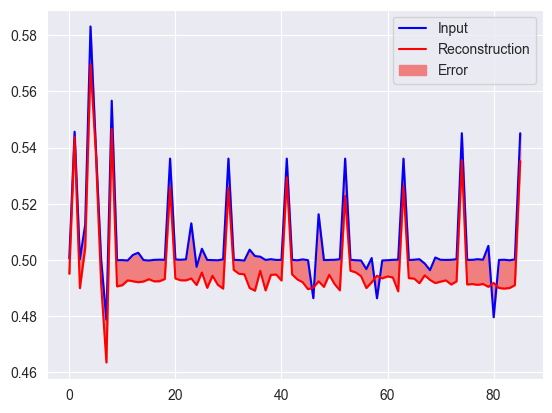

In [52]:
start_time = time()
normal_reconstructions = aae.autoencoder.predict(train_data)
end_time = time()
print(f'Time taken to reconstruct: {end_time - start_time}')

sample_inside_window = 4  # from 0 to WINDOW_SIZE
window_number = 38000  # from 0 to the number of windows created

# Plot the reconstruction error for each feature
plt.plot(train_data[window_number, :, sample_inside_window], 'b')
plt.plot(normal_reconstructions[window_number, :, sample_inside_window], 'r')
plt.fill_between(np.arange(86), normal_reconstructions[window_number, :, sample_inside_window],
                 train_data[window_number, :, sample_inside_window], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [53]:
def predict_discriminator(aae, data):
  rec = aae.autoencoder(data)
  output = aae.discriminator(rec)
  return output

In [63]:
preds = predict_discriminator(aae, test_data)
# print(preds.numpy().ravel())
print_stats(np.bitwise_not(preds.numpy().ravel().astype(bool)), np.ones_like(preds.numpy().ravel()))

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1 = 1.0
